In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import warnings

from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler

plt.rc('font', **{'size': 20})

In [2]:
def add_day_columns(df, timestamp_col, participant_df):
    return add_rel_day(add_start_day(add_day(df, timestamp_col), participant_df))

def add_day(df, timestamp_col):
    df = df.copy()
    df["Day"] = (df[timestamp_col]/(60*60*24)).apply(np.floor)
    return df

def add_start_day(df, participant_df):
    participant_df = participant_df.copy()
    participant_df["StartDay"] = (participant_df["DataStartStamp"]/(60*60*24)).apply(np.floor)
    return pd.merge(df, participant_df[['ParticipantId',"StartDay"]])

def add_rel_day(df):
    df = df.copy()
    df["RelDay"] = df["Day"]-df["StartDay"]
    return df

def scale(df, group_col, scale_col, scaler, postfix):
    for gid in set(df[group_col]):
        df.loc[df[group_col]==gid,[scale_col+postfix]] = scaler.fit_transform(df.loc[df[group_col]==gid,[scale_col]])

def get_trimmed_pids(df):
    df = df.copy()
    df = df[~df["Phone ER Interest"].isna()]
    df = df.groupby(["ParticipantId","RelDay"]).size().reset_index(drop=False)
    df = df.groupby(['ParticipantId']).size().reset_index(drop=False).rename(columns={0:"Count"})
    return df.loc[df.Count < 4,'ParticipantId'].tolist()

def sample_and_mean(x):
    return lambda g: g.mean() if g.shape[0] < x else g.sample(x).mean()

def largest_and_mean(x):
    return lambda g: g.nlargest(x).mean()

def smallest_and_mean(x):
    return lambda g: g.nsmallest(x).mean()

In [3]:
runs_df = pd.read_csv('../data/Runs.csv')
states_df = pd.read_csv('../data/States.csv')
emotions_df = pd.read_csv('../data/Emotions.csv')
participant_df = pd.read_csv('../data/Participants.csv')

emotions_df = emotions_df[emotions_df["WatchDataQuality"] == "Good"]

emotions_df["ER Interest"] = pd.to_numeric(emotions_df["ER Interest"], errors='coerce')
emotions_df["Phone ER Interest"] = pd.to_numeric(emotions_df["Phone ER Interest"], errors='coerce')
emotions_df["Response Time (min)"] = (emotions_df["OpenedTimestamp"] - emotions_df["DeliveredTimestamp"])/60

runs_df = add_day_columns(runs_df, "DeliveredTimestamp", participant_df)
states_df = add_day_columns(states_df, "TimestampUtc", participant_df)
emotions_df = add_day_columns(emotions_df, "OpenedTimestamp", participant_df)

to_trim = get_trimmed_pids(emotions_df)

runs_df = runs_df[~runs_df["ParticipantId"].isin(to_trim)]
states_df = states_df[~states_df["ParticipantId"].isin(to_trim)]
emotions_df = emotions_df[~emotions_df["ParticipantId"].isin(to_trim)]

runs_df = runs_df[runs_df["RelDay"] < 11]
states_df = states_df[states_df["RelDay"] < 11]
emotions_df = emotions_df[emotions_df["RelDay"] < 11]

warnings.filterwarnings("ignore", category=UserWarning)
scale(emotions_df, "ParticipantId", "Phone ER Interest", QuantileTransformer(n_quantiles=40), " (quant)")
scale(emotions_df, "ParticipantId", "Phone ER Interest", RobustScaler(), " (robust)")
scale(emotions_df, "ParticipantId", "Phone ER Interest", MinMaxScaler(), " (minmax)")
warnings.resetwarnings()

emotions_df.shape

(3650, 25)

In [5]:
def local():
    df = pd.read_csv('../data/Emotions.csv')
    df["ER Interest (num)"] = pd.to_numeric(df["ER Interest"], errors='coerce')
    df["Phone ER Interest (num)"] = pd.to_numeric(df["Phone ER Interest"], errors='coerce')
    df = df[["ER Interest (num)","ER Interest", "Phone ER Interest (num)","Phone ER Interest"]]
    print("All NA values are due to hyphens in the csv")
    print(((df["Phone ER Interest (num)"].isna() & (df["Phone ER Interest"] != "-")) | ((df["ER Interest (num)"].isna()) & (df["ER Interest"] != "-"))).sum())
local()

All NA values are due to hyphens in the csv
0


In [185]:
def local():
    df = pd.read_csv('../data/Emotions.csv')
    print("Almost all na values are due to an anxiety level of 1")
    print((((df["Phone ER Interest"] == "-") & (df["State Anxiety"]!=1))).sum())
local()

Almost all na values are due to an anxiety level of 1
2


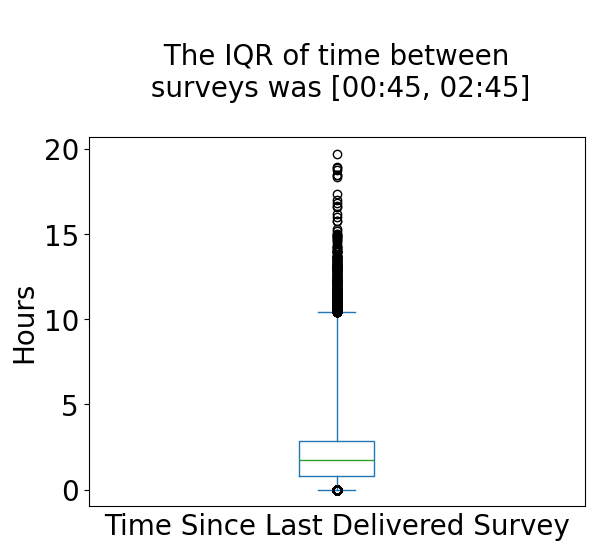

array([0.81, 2.87])

In [6]:
def local():
    deliveries = runs_df.sort_values(["ParticipantId","DeliveredTimestamp"]).reset_index(drop=True)
    diff = deliveries.groupby(["ParticipantId","RelDay"])["DeliveredTimestamp"].diff()
    (diff / (60*60)).plot.box(ylabel='Hours', whis=[5,95])
    plt.title("\n The IQR of time between \n surveys was [00:45, 02:45]\n", fontdict={"size":20})
    plt.xticks([])
    plt.xlabel("Time Since Last Delivered Survey")
    plt.show()
    return (np.nanpercentile(diff.tolist(),[25,75])/(60*60)).round(2)
local()

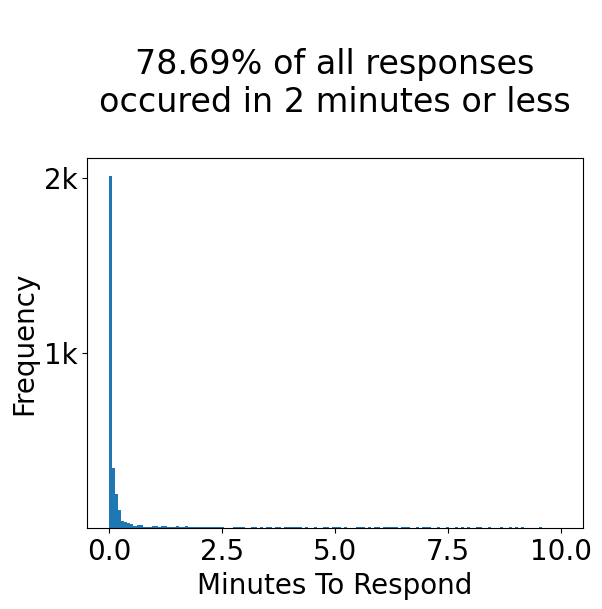

79.62

In [186]:
emotions_df[emotions_df["Response Time (min)"] < 10]["Response Time (min)"].plot(kind="hist",bins=150,)
plt.title("\n78.69% of all responses\noccured in 2 minutes or less\n")
plt.yticks([1000,2000],["1k","2k"])
plt.xlabel("Minutes To Respond")
plt.show()
round((emotions_df["Response Time (min)"] < 2).sum()/emotions_df.shape[0],4)*100

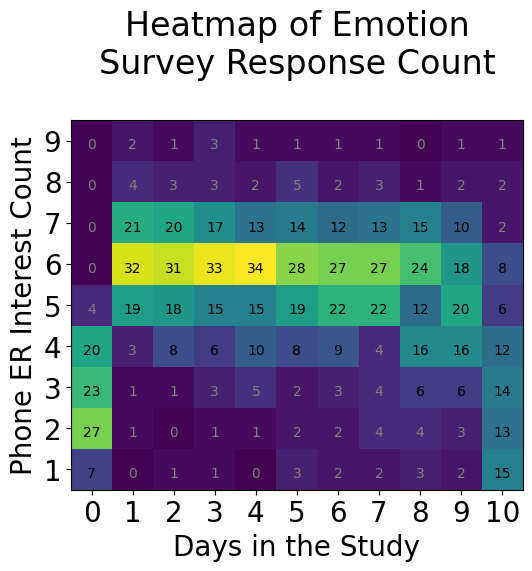

In [187]:
def local():
    df = pd.read_csv('../data/Emotions.csv')
    df = add_day_columns(df, "OpenedTimestamp", participant_df)
    to_trim = get_trimmed_pids(df)
    df = df[~df["ParticipantId"].isin(to_trim)]
    df = df[df["RelDay"] < 11]
    df = df[~df["Phone ER Interest"].isna()]
    df = df.groupby(["ParticipantId","RelDay"]).size().reset_index().rename(columns={0:"Count"})
    
    heatmap = np.histogram2d(df["RelDay"], df["Count"], bins=[11,9])[0]
    extent = (0, 11, 1, 10)
    plt.title("Heatmap of Emotion\nSurvey Response Count\n")
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            plt.gca().text(.5+i, 1.4+j, str(int(heatmap[i, j])), ha="center", va="center", color="black" if heatmap[i, j] >= 6 else "gray", fontdict={"size":10})
    plt.yticks([x+1.5 for x in range(9)],[str(x+1) for x in range(9)])
    plt.xticks([x+0.5 for x in range(11)],[str(x) for x in range(11)])
    plt.ylabel("Phone ER Interest Count")
    plt.xlabel("Days in the Study")
    plt.show()
local()

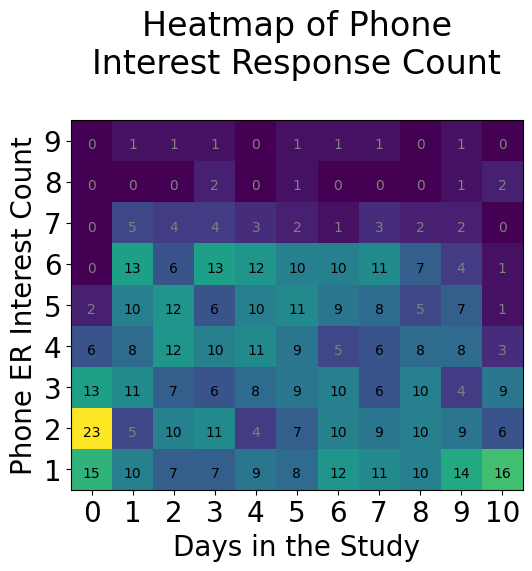

In [188]:
def local():
    
    df = emotions_df[~emotions_df["Phone ER Interest"].isna()].groupby(["ParticipantId","RelDay"]).size().reset_index().rename(columns={0:"Count"})
    heatmap = np.histogram2d(df["RelDay"], df["Count"], bins=[11,9])[0]
    extent = (0, 11, 1, 10)
    plt.title("Heatmap of Phone\nInterest Response Count\n")
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            plt.gca().text(.5+i, 1.4+j, str(int(heatmap[i, j])), ha="center", va="center", color="black" if heatmap[i, j] >= 6 else "gray", fontdict={"size":10})
    plt.yticks([x+0.5 for x in range(1,10)],[str(x) for x in range(1,10)])
    plt.xticks([x+0.5 for x in range(0,11)],[str(x) for x in range(0,11)])
    plt.ylabel("Phone ER Interest Count")
    plt.xlabel("Days in the Study")
    plt.show()
local()

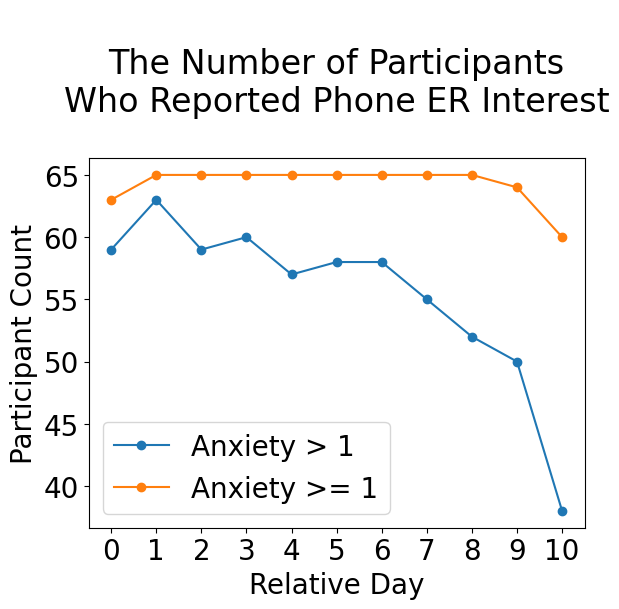

In [6]:
def local():
    groups = emotions_df[~emotions_df["Phone ER Interest"].isna()].groupby(["ParticipantId","RelDay"]).size().reset_index(drop=False)
    groups[["RelDay"]] = groups[["RelDay"]].astype(int)
    groups = groups.groupby(["RelDay"]).size()
    groups.plot(marker="o",label='Anxiety > 1')

    groups = emotions_df.groupby(["ParticipantId","RelDay"]).size().reset_index(drop=False)
    groups[["RelDay"]] = groups[["RelDay"]].astype(int)
    groups = groups.groupby(["RelDay"]).size()
    groups.plot(marker="o",label='Anxiety >= 1')

    plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
    plt.xlabel("Relative Day")
    plt.ylabel("Participant Count")
    plt.title("\nThe Number of Participants\nWho Reported Phone ER Interest\n")
    plt.legend()

local()

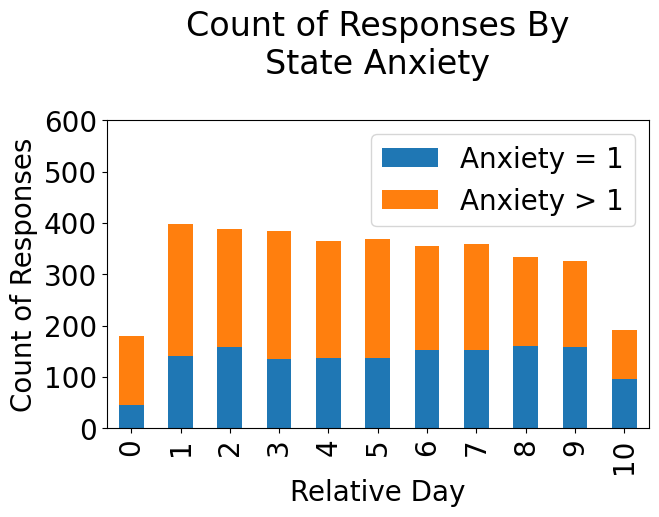

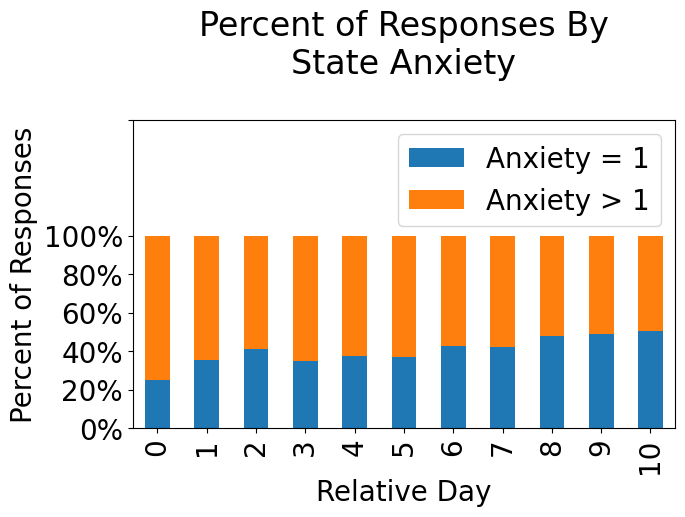

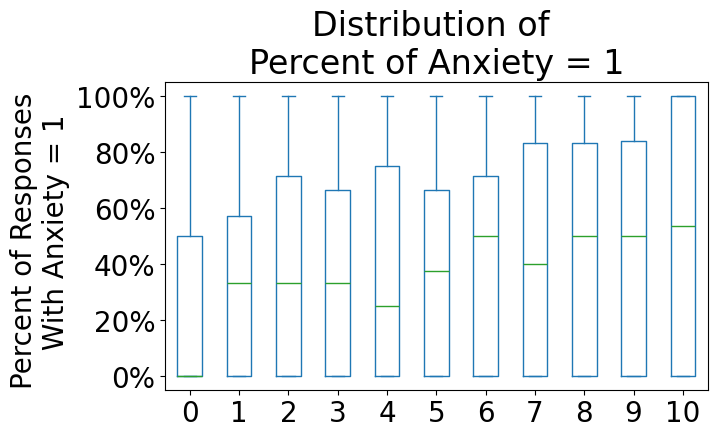

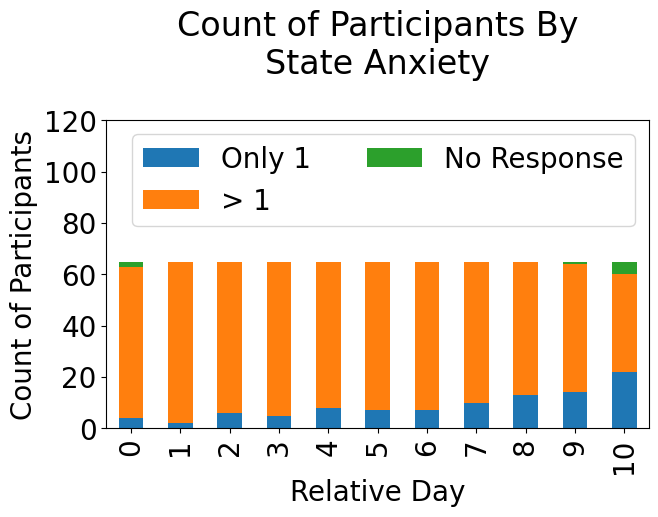

In [162]:
def local():
    anxiety_eq_1_count = emotions_df[emotions_df["State Anxiety"]==1].groupby(["RelDay"]).size()
    anxiety_gt_1_count = emotions_df[emotions_df["State Anxiety"]> 1].groupby(["RelDay"]).size()
    anxiety_ge_1_count = emotions_df[emotions_df["State Anxiety"]>=1].groupby(["RelDay"]).size()

    df = pd.concat([anxiety_eq_1_count,anxiety_gt_1_count],axis=1)
    df = df.rename(columns={0:"Anxiety = 1",1:"Anxiety > 1"})
    df.plot(kind="bar",stacked=True, figsize=(7,4))
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10],["0","1","2","3","4","5","6","7","8","9","10"])
    plt.yticks([0,100,200,300,400,500,600])
    plt.xlabel("Relative Day")
    plt.ylabel("Count of Responses")
    plt.title("Count of Responses By\nState Anxiety\n")
    plt.legend()
    plt.show()

    df = pd.concat([anxiety_eq_1_count/anxiety_ge_1_count,anxiety_gt_1_count/anxiety_ge_1_count],axis=1)
    df = df.rename(columns={0:"Anxiety = 1",1:"Anxiety > 1"})
    df.plot(kind="bar",stacked=True, figsize=(7,4))
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10],["0","1","2","3","4","5","6","7","8","9","10"])
    plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0,1.6],["0%","20%","40%","60%","80%","100%",""])
    plt.xlabel("Relative Day")
    plt.ylabel("Percent of Responses")
    plt.title("Percent of Responses By\nState Anxiety\n")
    plt.legend()
    plt.show()

    p_anxiety_eq_1_count = emotions_df[emotions_df["State Anxiety"]==1].groupby(["RelDay","ParticipantId"]).size()
    p_anxiety_gt_1_count = emotions_df[emotions_df["State Anxiety"]> 1].groupby(["RelDay","ParticipantId"]).size()
    p_anxiety_ge_1_count = emotions_df[emotions_df["State Anxiety"]>=1].groupby(["RelDay","ParticipantId"]).size()

    df = pd.concat([p_anxiety_eq_1_count,p_anxiety_ge_1_count],axis=1).fillna(0)
    participant_count = df.index.get_level_values("ParticipantId").unique().shape

    (df[0]/df[1]).reset_index(drop=False)[["RelDay",0]].plot.box(by="RelDay", figsize=(7,4))
    plt.title("Distribution of \nPercent of Anxiety = 1")
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11],["0","1","2","3","4","5","6","7","8","9","10"])
    plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0],["0%","20%","40%","60%","80%","100%"])
    plt.ylabel("Percent of Responses \n With Anxiety = 1")
    plt.show()

    eq_1_count = (df[0] == df[1]).groupby("RelDay").sum()
    ne_1_count = (df[0] != df[1]).groupby("RelDay").sum()
    none_count = participant_count-df[[1]].groupby("RelDay").size()

    df = pd.concat([eq_1_count,ne_1_count,none_count],axis=1)
    df = df.rename(columns={0:"Only 1",1:"> 1", 2:"No Response"})
    df.plot(kind="bar",stacked=True, figsize=(7,4))
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10],["0","1","2","3","4","5","6","7","8","9","10"])
    plt.yticks([0,20,40,60,80,100,120],["0","20","40","60","80","100","120"])
    plt.xlabel("Relative Day")
    plt.ylabel("Count of Participants")
    plt.title("Count of Participants By\nState Anxiety\n")

    plt.legend(ncols=2)
    plt.show()
    

local()

### ~88% of delivered Current Emotions Surveys Were Responded To

In [126]:
def local():
    emotions_df = runs_df[runs_df["ScriptName"] == "Current Emotions Survey"]
    return round(emotions_df["Submitted"].sum()/emotions_df.shape[0],4)*100
local()

88.42

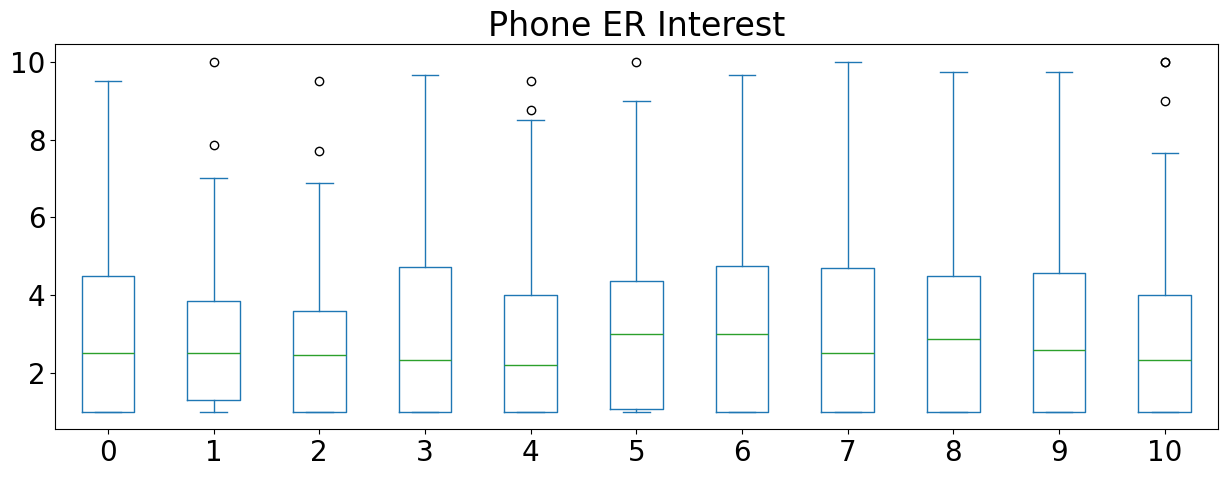

In [127]:
def local():
    col    = "Phone ER Interest"
    groups = emotions_df.groupby(["ParticipantId","RelDay"])[col].mean().reset_index(drop=False)
    groups = groups[["RelDay",col]]
    groups[["RelDay"]] = groups[["RelDay"]].astype(int)
    groups[["RelDay",col]].plot.box(by="RelDay",figsize=(15,5))
    plt.show()
local()

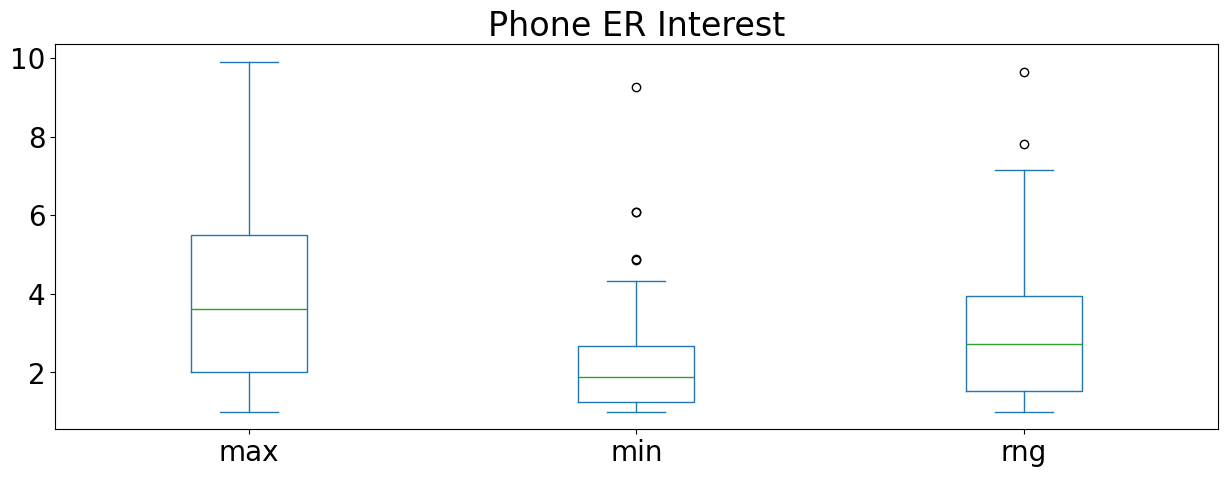

In [165]:
def local():
    col    = "Phone ER Interest"
    df = emotions_df.copy()
    max_means = df.groupby(["ParticipantId","RelDay"])[col].max().reset_index(drop=False)
    max_means = max_means.groupby(["ParticipantId"])[col].mean().reset_index(drop=False)
    rng_means = df.groupby(["ParticipantId"])[col].mean().reset_index(drop=False)
    min_means = df.groupby(["ParticipantId","RelDay"])[col].min().reset_index(drop=False)
    min_means = min_means.groupby(["ParticipantId"])[col].mean().reset_index(drop=False)

    max_means["type"] = "max"
    rng_means["type"] = "rng"
    min_means["type"] = "min"

    all_means = pd.concat([max_means,rng_means,min_means],axis=0)
    all_means[["type",col]].plot.box(by="type",figsize=(15,5))

    plt.xticks([1,2,3])

local()

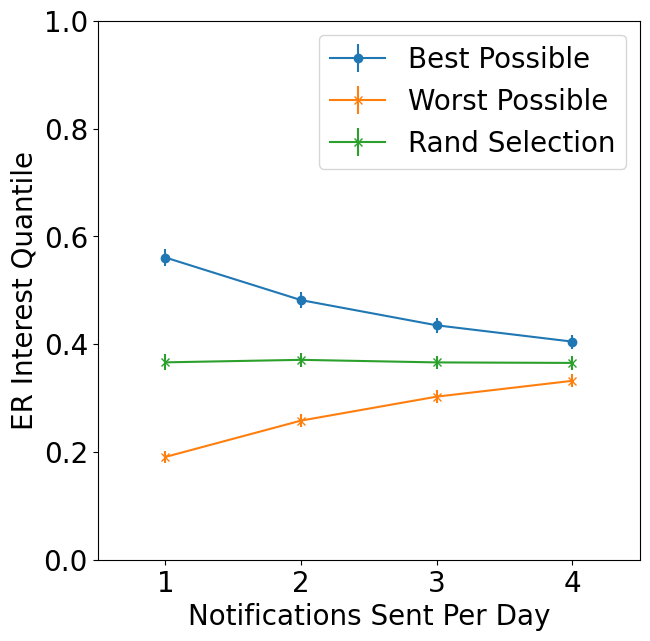

In [238]:
def local():
    groups = emotions_df.groupby(["ParticipantId","RelDay"])["Phone ER Interest (quant)"]

    #Best
    best_y = lambda x: groups.apply(largest_and_mean(x)).tolist()

    #Worst
    worst_y = lambda x: groups.apply(smallest_and_mean(x)).tolist()

    #rand
    rand_y = lambda x: groups.apply(sample_and_mean(x)).tolist()

    xs = [1,2,3,4]

    best_ys = list(map(best_y,xs))
    worst_ys = list(map(worst_y,xs))
    rand_ys = list(map(rand_y,xs))

    ys  = lambda Ys: list(map(np.mean,Ys))
    var = lambda Ys: [ np.var(ys) for ys in Ys]
    sd  = lambda Ys: [ np.std(ys) for ys in Ys]
    se  = lambda Ys: [ np.std(ys)/np.sqrt(len(ys)) for ys in Ys]
    hi  = lambda Ys: [ np.percentile(ys,65)-np.median(ys) for ys in Ys]
    lo  = lambda Ys: [ np.median(ys)-np.percentile(ys,35) for ys in Ys]

    #yerr=[lo(best_ys),hi(best_ys)]

    plt.figure(figsize=(7,7))

    plt.errorbar(xs,ys(best_ys), se(best_ys), marker='o', label="Best Possible")
    plt.errorbar(xs,ys(worst_ys), se(worst_ys), marker='x', label="Worst Possible")
    plt.errorbar(xs,ys(rand_ys), se(rand_ys), marker='x', label="Rand Selection")

    plt.xlim(.5,4.5)
    plt.ylim(0,1)
    plt.legend(loc='upper right')
    plt.ylabel("ER Interest Quantile")
    plt.xlabel("Notifications Sent Per Day")
local()

In [ ]:
def local():
    col    = "Phone ER Interest"
    groups = emotions_df.groupby(["ParticipantId","RelDay"])[col].mean().reset_index(drop=False)
    groups = groups[["RelDay",col]]
    groups[["RelDay"]] = groups[["RelDay"]].astype(int)
    groups[["RelDay",col]].plot.box(by="RelDay",figsize=(15,7))
    plt.show()
local()

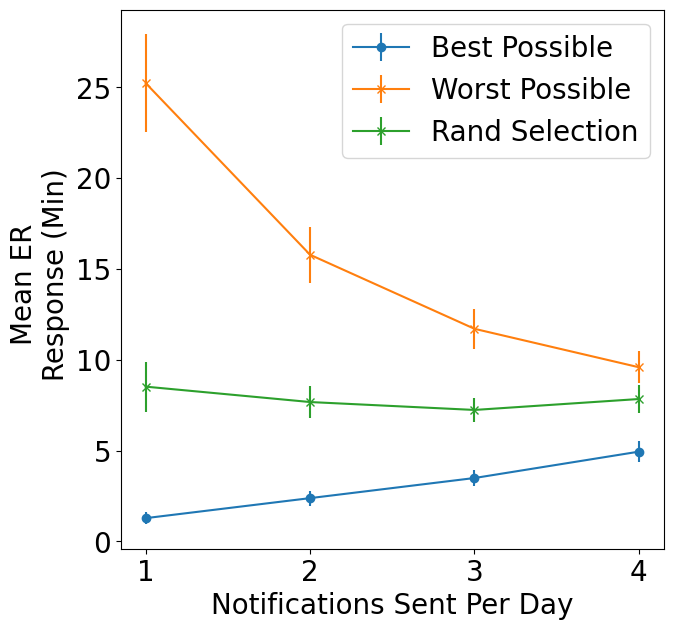

In [65]:
def local():
    groups = emotions_df.groupby(["ParticipantId","RelDay"])["Response Time (min)"]

    #Best
    best_y = lambda x: groups.apply(smallest_and_mean(x)).tolist()

    #Worst
    worst_y = lambda x: groups.apply(largest_and_mean(x)).tolist()

    #rand
    rand_y = lambda x: groups.apply(sample_and_mean(x)).tolist()

    xs = [1,2,3,4]

    best_ys = list(map(best_y,xs))
    worst_ys = list(map(worst_y,xs))
    rand_ys = list(map(rand_y,xs))

    ys  = lambda Ys: list(map(np.mean,Ys))
    var = lambda Ys: [ np.var(ys) for ys in Ys]
    sd  = lambda Ys: [ np.std(ys) for ys in Ys]
    se  = lambda Ys: [ np.std(ys)/np.sqrt(len(ys)) for ys in Ys]
    hi  = lambda Ys: [ np.percentile(ys,65)-np.median(ys) for ys in Ys]
    lo  = lambda Ys: [ np.median(ys)-np.percentile(ys,35) for ys in Ys]

    #yerr=[lo(best_ys),hi(best_ys)]

    plt.figure(figsize=(7,7))

    plt.errorbar(xs,ys(best_ys), se(best_ys), marker='o', label="Best Possible")
    plt.errorbar(xs,ys(worst_ys), se(worst_ys), marker='x', label="Worst Possible")
    plt.errorbar(xs,ys(rand_ys), se(rand_ys), marker='x', label="Rand Selection")

    #plt.xlim(.5,4.5)
    #plt.ylim(1,5)
    plt.legend(loc='upper right')
    plt.ylabel("Mean ER \n Response (Min)")
    plt.xlabel("Notifications Sent Per Day")
local()

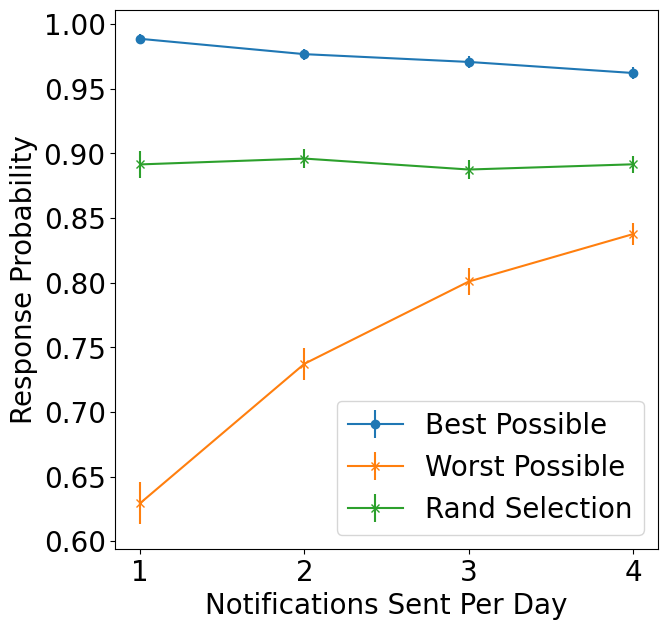

In [244]:
def local():
    
    emotion_runs = runs_df[runs_df["ScriptName"] == "Current Emotions Survey"]

    groups = emotion_runs.groupby(["ParticipantId","RelDay"])["Submitted"]

    #Best
    best_y = lambda x: groups.apply(largest_and_mean(x)).tolist()

    #Worst
    worst_y = lambda x: groups.apply(smallest_and_mean(x)).tolist()

    #rand
    rand_y = lambda x: groups.apply(sample_and_mean(x)).tolist()

    xs = [1,2,3,4]

    best_ys = list(map(best_y,xs))
    worst_ys = list(map(worst_y,xs))
    rand_ys = list(map(rand_y,xs))

    ys  = lambda Ys: list(map(np.mean,Ys))
    var = lambda Ys: [ np.var(ys) for ys in Ys]
    sd  = lambda Ys: [ np.std(ys) for ys in Ys]
    se  = lambda Ys: [ np.std(ys)/np.sqrt(len(ys)) for ys in Ys]
    hi  = lambda Ys: [ np.percentile(ys,65)-np.median(ys) for ys in Ys]
    lo  = lambda Ys: [ np.median(ys)-np.percentile(ys,35) for ys in Ys]

    #yerr=[lo(best_ys),hi(best_ys)]

    plt.figure(figsize=(7,7))

    plt.errorbar(xs,ys(best_ys), se(best_ys), marker='o', label="Best Possible")
    plt.errorbar(xs,ys(worst_ys), se(worst_ys), marker='x', label="Worst Possible")
    plt.errorbar(xs,ys(rand_ys), se(rand_ys), marker='x', label="Rand Selection")

    #plt.xlim(.5,4.5)
    #plt.ylim(1,5)
    plt.legend(loc='lower right')
    plt.ylabel("Response Probability")
    plt.xlabel("Notifications Sent Per Day")
local()

In [177]:
def local():
    import statsmodels.formula.api as smf

    df = emotions_df.copy()
    
    df["Response_Time"] = df["Response Time (min)"]
    df["Phone_ER_Interest"] = df["Phone ER Interest"]

    df = df[~df["Response Time (min)"].isna()]
    df = df[~df["Phone ER Interest"].isna()]

    df = df.reset_index(drop=True)

    md1 = smf.mixedlm("Phone_ER_Interest ~ 1 + np.log(.1+Response_Time)", groups=df["ParticipantId"], re_formula="~ 1 + np.log(.1+Response_Time)", data=df)
    md2 = smf.ols("Phone_ER_Interest ~ 1 + np.log(.05+Response_Time)", df)

    print(md1.fit(method='lbfgs').summary())
    print(md2.fit().summary())
local()

                      Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Phone_ER_Interest
No. Observations:       2048          Method:                   REML             
No. Groups:             53            Scale:                    3.0411           
Min. group size:        12            Log-Likelihood:           -4150.8240       
Max. group size:        80            Converged:                Yes              
Mean group size:        38.6                                                     
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               3.118    0.262 11.882 0.000  2.604  3.632
np.log(.1 + Response_Time)             -0.030    0.026 -1.138 0.255 -0.082  0.022
Group Var                             

/home/mrucker/miniconda3/envs/diss/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [115]:
def local():
    import statsmodels.formula.api as smf

    df = emotions_df.copy()
    df["ER_Interest"] = df["ER Interest"]
    df["Phone_ER_Interest"] = df["Phone ER Interest"]

    df = df[~df["ER Interest"].isna()]
    df = df[~df["Phone ER Interest"].isna()]

    df = df.reset_index(drop=True)

    md1 = smf.mixedlm("ER_Interest ~ 1 + Phone_ER_Interest", df, groups=df["ParticipantId"], re_formula="~ 1 + Phone_ER_Interest")
    md2 = smf.ols("ER_Interest ~ 1 + Phone_ER_Interest", df)

    print(md1.fit(method=["lbfgs"]).summary())
    print(md2.fit().summary())
local()

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      ER_Interest
No. Observations:      2048         Method:                  REML       
No. Groups:            53           Scale:                   2.3682     
Min. group size:       12           Log-Likelihood:          -3872.8841 
Max. group size:       80           Converged:               Yes        
Mean group size:       38.6                                             
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      1.275    0.156  8.159 0.000  0.969  1.581
Phone_ER_Interest              0.663    0.039 17.077 0.000  0.587  0.739
Group Var                      0.976    0.163                           
Group x Phone_ER_Interest Cov -0.166    0.037                        

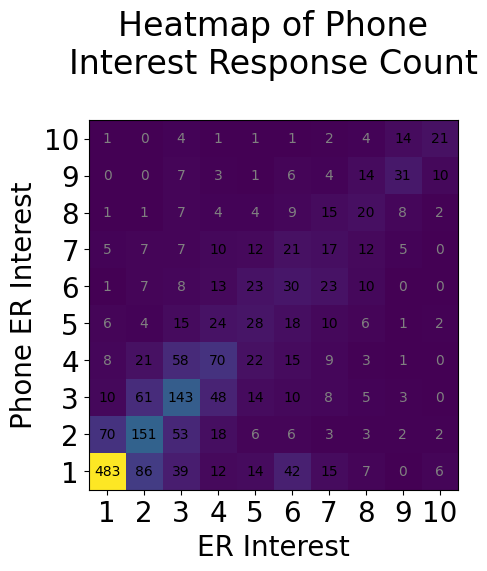

In [168]:
def local():
    df = emotions_df.copy()

    df = df[~df["ER Interest"].isna()]
    df = df[~df["Phone ER Interest"].isna()]

    heatmap = np.histogram2d(df["ER Interest"], df["Phone ER Interest"], bins=[1,2,3,4,5,6,7,8,9,10,11])[0]

    extent = (1, 11, 1, 11)

    plt.title("Heatmap of Phone\nInterest Response Count\n")
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            plt.gca().text(1.5+i, 1.5+j, str(int(heatmap[i, j])), ha="center", va="center", color="black" if heatmap[i, j] >= 10 else "gray", fontdict={"size":10})
    plt.yticks([x+0.5 for x in range(1,11)],[str(x) for x in range(1,11)])
    plt.xticks([x+0.5 for x in range(1,11)],[str(x) for x in range(1,11)])
    plt.ylabel("Phone ER Interest")
    plt.xlabel("ER Interest")
    plt.show()
local()

In [110]:
def local():
    import statsmodels.formula.api as smf

    X = 10*np.random.rand(1000)
    y = (200 + 200*np.random.rand(1000) + 1000*X**2)

    df = pd.DataFrame({"X":X, "y":y})

    md = smf.ols("y ~ 1 + X", df)
    mr = md.fit()
    print(mr.summary())
    print(mr.aic)
local()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.479e+04
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:23:43   Log-Likelihood:                -10338.
No. Observations:                1000   AIC:                         2.068e+04
Df Residuals:                     998   BIC:                         2.069e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.608e+04    472.657    -34.019      0.0

Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, X]


Output()

Sampling 2 chains for 1_000 tune and 10 draw iterations (2_000 + 20 draws total) took 4 seconds.
The number of samples is too small to check convergence reliably.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,302.158,1.846,299.430,304.930,0.362,0.259,22.0,22.0,1.22
X,999.943,0.497,998.914,1000.364,0.097,0.070,26.0,22.0,1.05


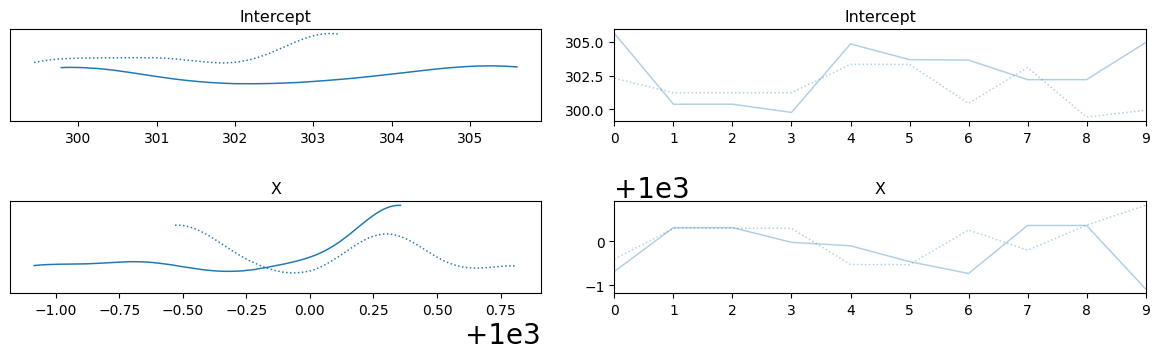

In [6]:
def local():
    import bambi as bmb
    import arviz as az

    X = 10*np.random.rand(1000)
    y = (200 + 200*np.random.rand(1000) + 1000*X)

    df = pd.DataFrame({"X":X, "y":y})

    md = bmb.Model("y ~ X", df)
    mr = md.fit(draws=10,tune=1000,cores=2)

    az.plot_trace(mr, var_names=["Intercept", "X"], compact=True)
    plt.tight_layout()
    return az.summary(mr, var_names=["Intercept", "X"])

local()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, Intercept, Response_Time, 1|ParticipantId_sigma, 1|ParticipantId_offset, Response_Time|ParticipantId_sigma, Response_Time|ParticipantId_offset]


Output()

Sampling 16 chains for 4_000 tune and 1_000 draw iterations (64_000 + 16_000 draws total) took 2355 seconds.
There were 3000 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 13 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 14 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/home/mrucker/minicon

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.277,2.763,-4.655,4.199,0.688,0.496,18.0,19.0,3.13
Response_Time,0.036,0.287,-0.540,0.556,0.071,0.051,18.0,16.0,3.01


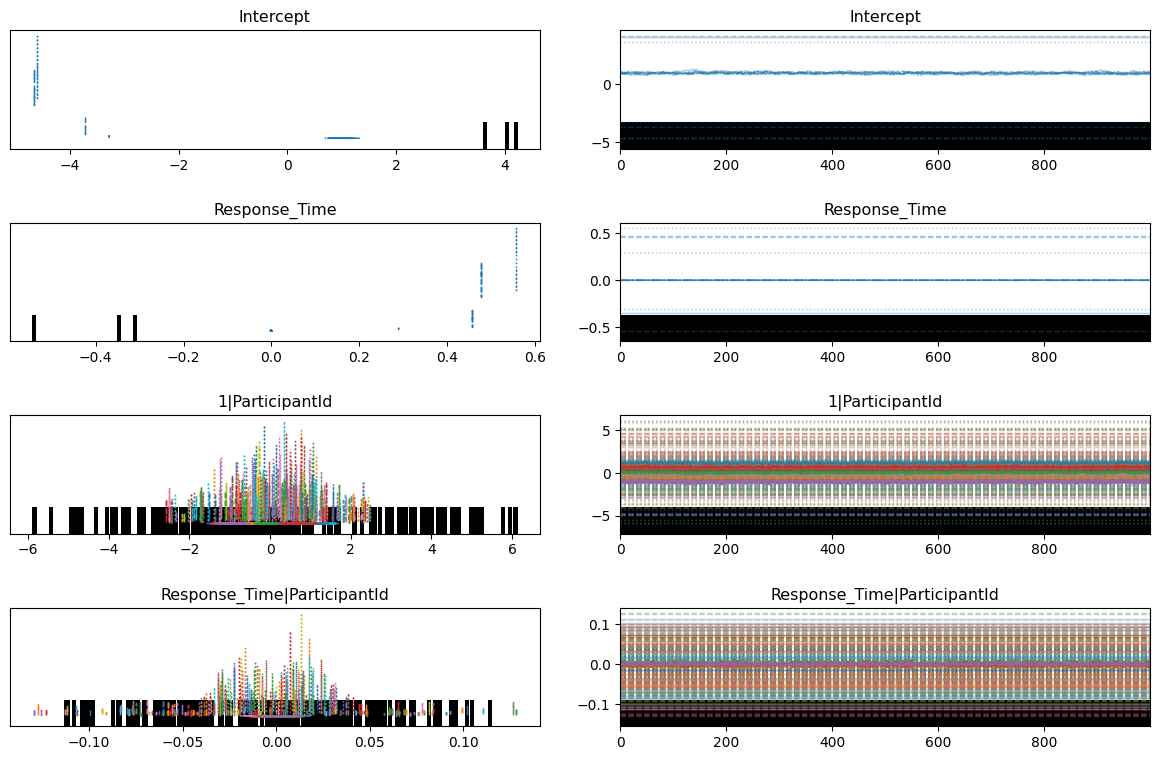

In [7]:
def local():
    import bambi as bmb
    import arviz as az

    df = emotions_df.copy()

    df["Response_Time"] = .25+df["Response Time (min)"]
    df["Phone_ER_Interest"] = df["Phone ER Interest"]

    df = df[~df["Response Time (min)"].isna()]
    df = df[~df["Phone ER Interest"].isna()]

    df = df.reset_index(drop=True)

    md = bmb.Model("Phone_ER_Interest ~ Response_Time + (Response_Time|ParticipantId)", df, family="gamma", link="log")
    mr = md.fit(tune=4000, target_accept=.95, cores=16)

    az.plot_trace(mr, var_names=["Intercept", "Response_Time", "1|ParticipantId", "Response_Time|ParticipantId"], compact=True)
    plt.tight_layout()

    return az.summary(mr, var_names=["Intercept", "Response_Time"])
local()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma, Intercept, ER_Interest, 1|ParticipantId_sigma, 1|ParticipantId_offset, ER_Interest|ParticipantId_sigma, ER_Interest|ParticipantId_offset]


Output()

Sampling 16 chains for 4_000 tune and 1_000 draw iterations (64_000 + 16_000 draws total) took 128 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.316,0.123,1.082,1.544,0.001,0.001,10835.0,12123.0,1.0
ER_Interest,0.513,0.040,0.437,0.586,0.001,0.000,5886.0,8791.0,1.0


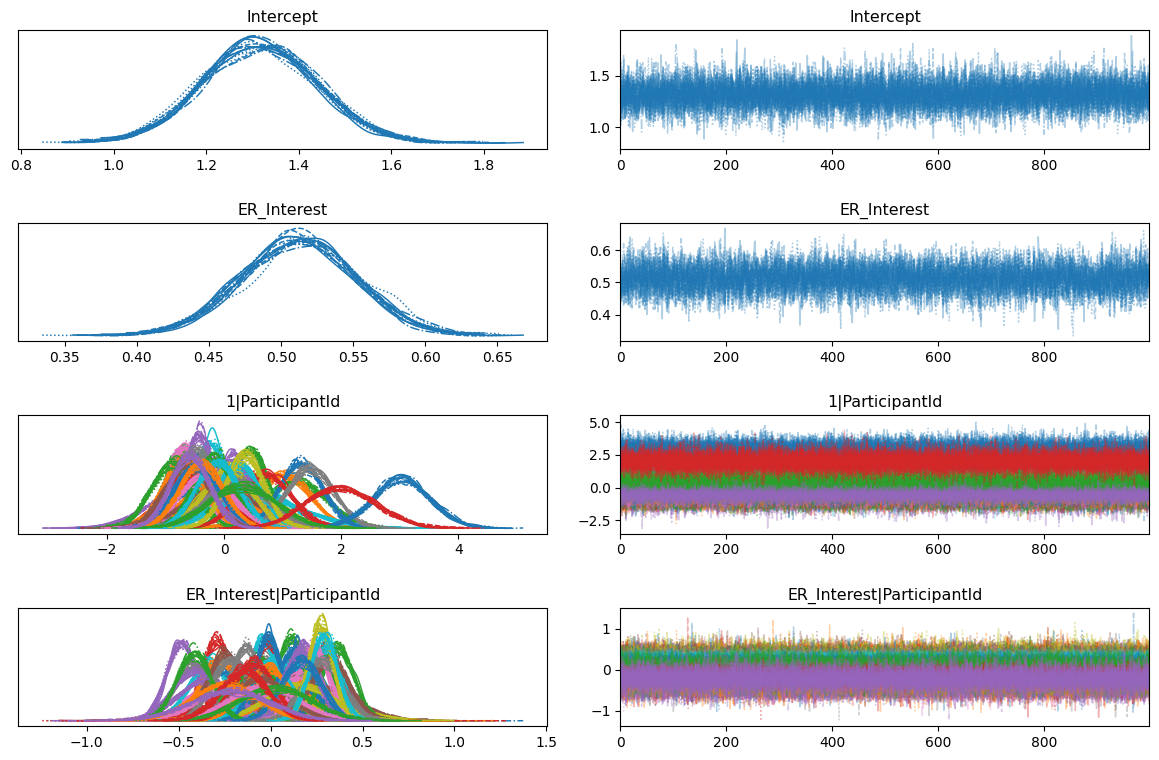

In [19]:
def local():
    import bambi as bmb
    import arviz as az

    df = emotions_df.copy()

    df = df[~df["Response Time (min)"].isna()]
    df = df[~df["Phone ER Interest"].isna()]

    df["ER_Interest"] = df["ER Interest"]
    df["Phone_ER_Interest"] = df["Phone ER Interest"]

    df = df.reset_index(drop=True)

    md = bmb.Model("Phone_ER_Interest ~ ER_Interest + (ER_Interest|ParticipantId)", df, family="gaussian", link="log")
    mr = md.fit(tune=4000, target_accept=.95, cores=16)

    az.plot_trace(mr, var_names=["Intercept", "ER_Interest", "1|ParticipantId", "ER_Interest|ParticipantId"], compact=True)
    plt.tight_layout()

    return az.summary(mr, var_names=["Intercept", "ER_Interest"])
local()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, Intercept, RelDay, 1|ParticipantId_sigma, 1|ParticipantId_offset, RelDay|ParticipantId_sigma, RelDay|ParticipantId_offset]


Output()

Sampling 16 chains for 4_000 tune and 1_000 draw iterations (64_000 + 16_000 draws total) took 193 seconds.


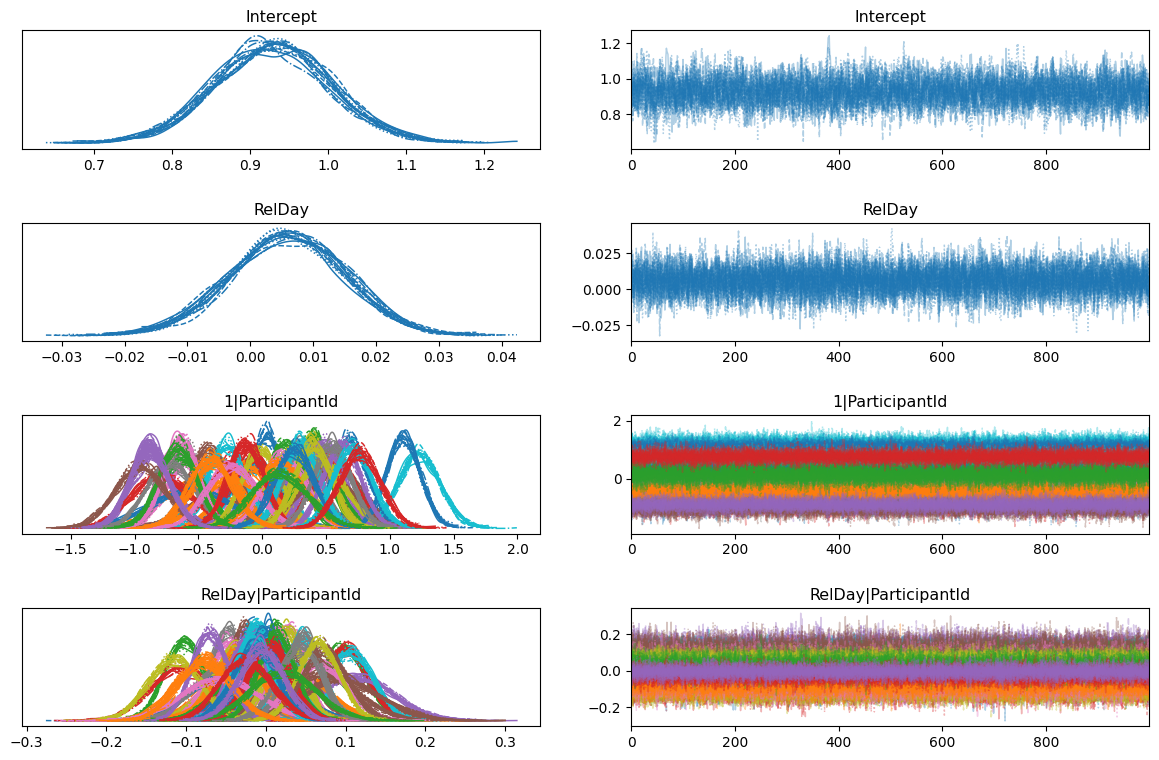

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.929,0.074,0.794,1.073,0.001,0.001,3638.0,6591.0,1.0
RelDay,0.006,0.009,-0.011,0.023,0.000,0.000,7532.0,10109.0,1.0


In [ ]:
def local():
    import bambi as bmb
    import arviz as az

    df = emotions_df.copy()

    df = df[~df["Phone ER Interest"].isna()]

    df["Phone_ER_Interest"] = df["Phone ER Interest"]

    df = df.reset_index(drop=True)

    md = bmb.Model("Phone_ER_Interest ~ RelDay + (RelDay|ParticipantId)", df, family="gamma", link="log")
    mr = md.fit(tune=4000, target_accept=.95, cores=16)

    az.plot_trace(mr, var_names=["Intercept", "RelDay", "1|ParticipantId", "RelDay|ParticipantId"], compact=True)
    plt.tight_layout()
    plt.show()

    return az.summary(mr, var_names=["Intercept", "RelDay"])
local()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, Intercept, RelDay, 1|ParticipantId_sigma, 1|ParticipantId_offset, RelDay|ParticipantId_sigma, RelDay|ParticipantId_offset]


Output()

Sampling 16 chains for 4_000 tune and 1_000 draw iterations (64_000 + 16_000 draws total) took 543 seconds.


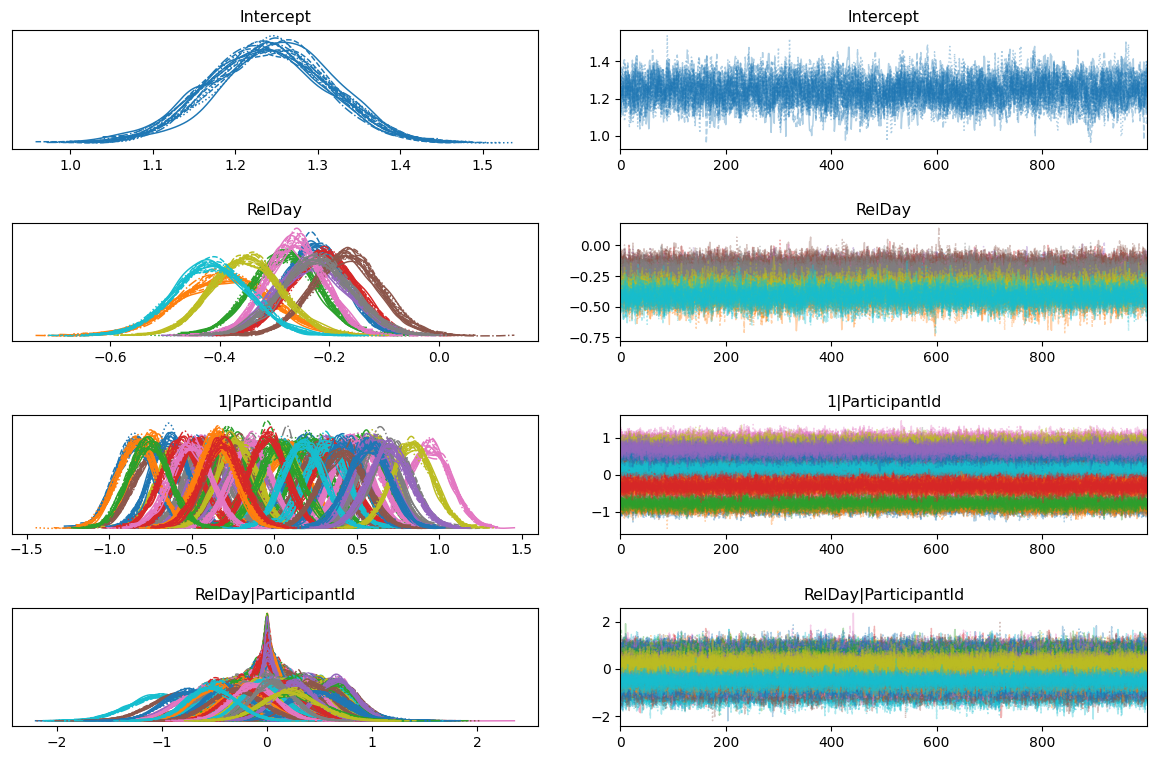

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.242,0.071,1.110,1.377,0.002,0.001,2068.0,4742.0,1.01
RelDay[1.0],-0.226,0.054,-0.327,-0.126,0.001,0.000,7561.0,10448.0,1.00
RelDay[10.0],-0.391,0.083,-0.548,-0.240,0.001,0.001,6848.0,9478.0,1.00
RelDay[2.0],-0.281,0.060,-0.402,-0.174,0.001,0.001,7198.0,9365.0,1.00
RelDay[3.0],-0.211,0.060,-0.322,-0.098,0.001,0.000,7510.0,10109.0,1.00
RelDay[4.0],-0.230,0.067,-0.358,-0.104,0.001,0.001,6929.0,8614.0,1.00
RelDay[5.0],-0.169,0.061,-0.282,-0.052,0.001,0.001,7128.0,9995.0,1.00
RelDay[6.0],-0.262,0.052,-0.360,-0.164,0.001,0.000,7996.0,10279.0,1.00
RelDay[7.0],-0.223,0.065,-0.346,-0.104,0.001,0.001,6867.0,9859.0,1.00
RelDay[8.0],-0.352,0.063,-0.465,-0.230,0.001,0.001,7877.0,10162.0,1.00


In [ ]:
def local():
    import bambi as bmb
    import arviz as az

    df = emotions_df.copy()

    df["State_Anxiety"] = df["State Anxiety"]    
    df["RelDay"] = df["RelDay"].astype(str)

    df = df.reset_index(drop=True)

    md = bmb.Model("State_Anxiety ~ RelDay + (RelDay|ParticipantId)", df, family="gamma", link="log")
    mr = md.fit(tune=4000, target_accept=.95, cores=4)

    az.plot_trace(mr, var_names=["Intercept", "RelDay", "1|ParticipantId", "RelDay|ParticipantId"], compact=True)
    plt.tight_layout()
    plt.show()

    return az.summary(mr, var_names=["Intercept", "RelDay"])
local()

In [ ]:
def local():
    import bambi as bmb
    import arviz as az
    from scipy import stats

    df = emotions_df.copy()

    df = df[~df["Response Time (min)"].isna()]
    df = df[~df["Phone ER Interest"].isna()]
    df = df[df["Response Time (min)"]<20]

    df["Response_Time"] = np.log(1+df["Response Time (min)"])
    #df["Response_Time"] = 1+df["Response Time (min)"]/df["Response Time (min)"].max()
    #df["Response_Time"] = stats.boxcox(.25+df["Response Time (min)"],lmbda=.05)
    df["Phone_ER_Interest"] = df["Phone ER Interest"]

    #plt.hist(df["Response_Time"],bins=30)

    md = bmb.Model("Phone_ER_Interest ~ Response_Time + (Response_Time|ParticipantId)", df, family="gamma", link="log")
    mr = md.fit(tune=4000, target_accept=.95, cores=16)

    az.plot_trace(mr, var_names=["Intercept", "Response_Time", "1|ParticipantId", "Response_Time|ParticipantId"], compact=True)
    plt.tight_layout()

    return az.summary(mr, var_names=["Intercept", "Response_Time"])
local()

1.0
10.0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, Intercept, Response_Time, 1|ParticipantId_sigma, 1|ParticipantId_offset, Response_Time|ParticipantId_sigma, Response_Time|ParticipantId_offset]


Output()

ValueError: Not enough samples to build a trace.